In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries import StandardRegressiveModel
from u8timeseries.models.theta import Theta
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr, get_train_val_series, backtest_autoregressive_model
from u8timeseries.models.statistics import check_seasonality, plot_acf #, plot_pacf

from u8timeseries.utils.missing_values import auto_fillna
from u8timeseries.utils import TimeSeriesDataset1D
from u8timeseries import RNN, RNNModel

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
import torch
import torch.nn as nn

## Read data

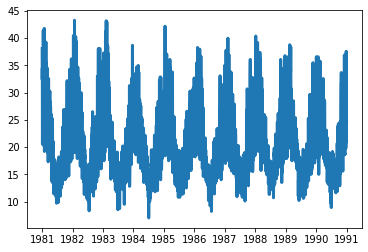

In [6]:
df = pd.read_csv('dataset/daily-max-temperature.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Date', 'Temperature')
series.plot(lw=3)

__Missing dates are present, detected and inserted__

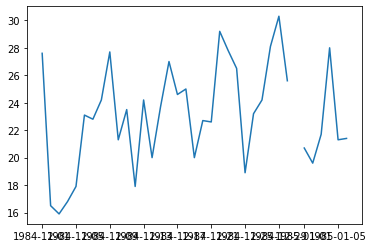

In [7]:
series['19841201':'19850107'].plot()

In [12]:
series = auto_fillna(series, interpolate='linear')

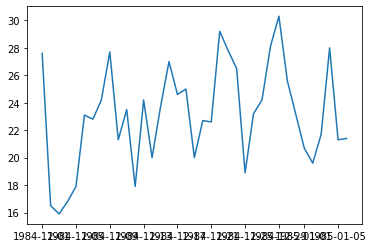

In [13]:
series['19841201':'19850107'].plot()

## Exploration

Before building any kind of model, it is good to understand the characteristics of our TimeSeries.

The data seems to have a seasonal trend, with a yearly period. 
The existence of such a trend can be explored using the auto-correlation function (ACF).

The result is noisy (due to the high frequency in the original data), but the yearly period can be observed

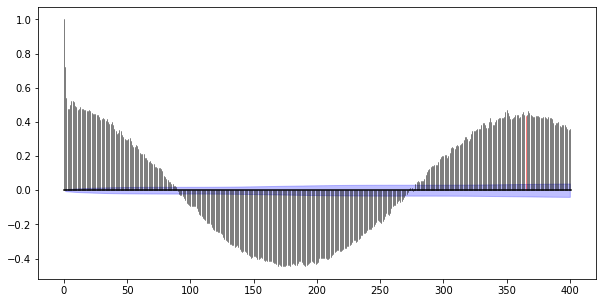

In [21]:
plot_acf(series, m = 365, alpha = .05, max_lag=400)

<Figure size 720x360 with 0 Axes>

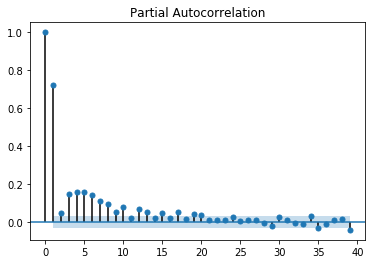

In [15]:
plot_pacf(series, alpha = .05, max_lag=40)  # TODO: do we need to low-pass filter the result?

The noise can lead to false detection.

In [18]:
for i in range(2, 380):
    season, period = check_seasonality(series, m = i, alpha = .05, max_lag=400)
    
    if season:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 7.
There is seasonality of order 13.
There is seasonality of order 20.
There is seasonality of order 31.
There is seasonality of order 38.
There is seasonality of order 44.
There is seasonality of order 52.
There is seasonality of order 57.
There is seasonality of order 62.
There is seasonality of order 280.
There is seasonality of order 282.
There is seasonality of order 294.
There is seasonality of order 302.
There is seasonality of order 307.
There is seasonality of order 318.
There is seasonality of order 324.
There is seasonality of order 331.
There is seasonality of order 337.
There is seasonality of order 345.
There is seasonality of order 350.
There is seasonality of order 358.
There is seasonality of order 363.
There is seasonality of order 367.
There is seasonality of order 374.
There is seasonality of order 379.


A stastical check confirms our intuition!

## Build three models

In [22]:
model_es = ExponentialSmoothing(seasonal_periods=365)
model_pr = Prophet(yearly_seasonality=True)
model_ar = AutoArima()
model_bl = KthValueAgoBaseline(k=365)

## Try one of the models
Here we'll just do a one shot prediction. Prediction time will be 1957-01-01, and we'll forecast the rest of the time series from that point on.

Definition: *prediction time* is the time *at which* a forecast is made, and *forecast time* is the time *for which* the forecast is made.

For instance, in the example below, prediction time is 1957-01-01, and forecast time is the time range between 1957-02-01 and the end of the time series.

The error will be measured using the MAPE error function.

### baseline

In [23]:
train, val = series.split_after(pd.Timestamp('19890101'))
model_bl.fit(train)
pred = model_bl.predict(len(val))

print('The MASE is: {:.3f}'.format(mase(val, pred, 365)))

The MASE is: 1.057


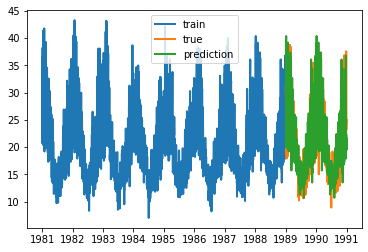

In [24]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

### exponential smoothing

In [25]:
train, val = series.split_after(pd.Timestamp('19890101'))
model_es.fit(train)
pred = model_es.predict(len(val))

print('The MASE is: {:.3f}'.format(mase(val, pred, 365)))

The MASE is: 0.809


C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



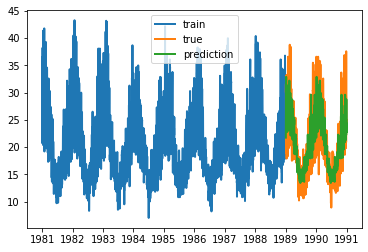

In [26]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

### Prophet

In [27]:
train, val = series.split_after(pd.Timestamp('19890101'))
model_pr.fit(train)
pred = model_pr.predict(len(val))

print('The MASE is: {:.3f}'.format(mase(val, pred, 365)))

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\fbprophet\forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



The MASE is: 0.850


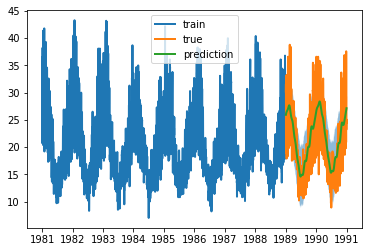

In [28]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

### arima

In [29]:
train, val = series.split_after(pd.Timestamp('19890101'))
model_ar.fit(train)
pred = model_ar.predict(len(val))

print('The MASE is: {:.3f}'.format(mase(val, pred, 365)))

The MASE is: 1.156


C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



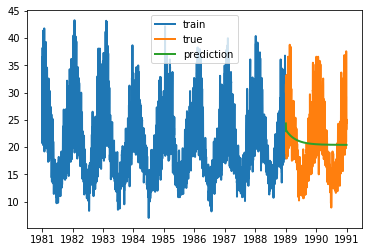

In [30]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

### The Theta method

The module theta.py contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has known great success, particularly in the M3-competition.

Though the value of the Theta parameter is mainly set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. As an example, we will apply this process to our Air Passenger data.

In [48]:
# theta = 0 is the default parameter.
model_theta_0 = Theta(mode='add')

# We know that there is a yearly seasonality, so we include the parameter season_period.
model_theta_0.fit(train, season_period = 365)
pred_theta_0 = model_theta_0.predict(len(val))

print('The MASE is: {:.3f}'.format(mase(val, pred_theta_0, 365)))

The MASE is: 0.789


C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



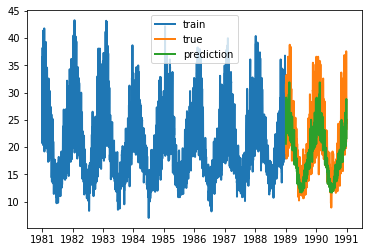

In [49]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred_theta_0.plot(lw=2, label='prediction')
plt.legend()

Clearly this prediction not as good as the exponential smoothing above. But what about different values of theta?

In [50]:
# Search for the best theta parameter.
thetas = np.linspace(-10, 10, 200)


# The best configuration is, for now, the only one we know: with theta = 0, computed above.
best_mase = 1
best_theta = 0

for theta in thetas:
    model = Theta(theta, mode='add')
    model.fit(train, 365)
    pred_theta = model.predict(len(val))
    res = mase(val, pred_theta, 365)
    
    if res < best_mase:
        best_mase = res
        best_theta = theta

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:293: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:294: FutureWarning:

RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead

C:\ProgramData\Miniconda3\envs\u8timeseries\lib\site-packages\statsmodels\tsa\base\tsa_model.py:296: FutureWarning:

RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead



In [51]:
model = Theta(best_theta)
model.fit(train, 365)
pred_best_theta = model.predict(len(val))

print('The MASE is: {:.3f}, with theta = {}.'.format(mase(val, pred_best_theta, 364), best_theta))

The MASE is: 0.772, with theta = 1.959798994974875.


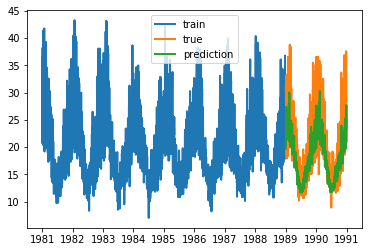

In [52]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred_best_theta.plot(lw=2, label='prediction')
plt.legend()
plt.show()

### RNN 

In [12]:
train, val = series.split_after(pd.Timestamp('19890101'))

In [16]:
# Number of features/channels used as input.
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
INPUT_LENGTH = 365
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LENGTH = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [33]:
my_model = RNNModel('LSTM', INPUT_SIZE, OUTPUT_LENGTH, INPUT_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=128, n_epochs=600, exp_name='Temp_LSTM', vis_tb=True)

In [34]:
my_model.set_optimizer(torch.optim.Adam, learning_rate=4e-3)
my_model.set_scheduler(torch.optim.lr_scheduler.ExponentialLR, gamma=0.995)

In [35]:
my_model.set_val_series(val)

In [36]:
my_model.fit(train)

Training loss: 0.0247, validation loss: 0.0350


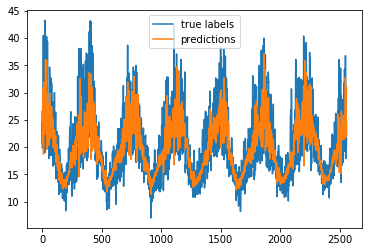

MSE: 14.643414


In [37]:
my_model.plot_result_train()

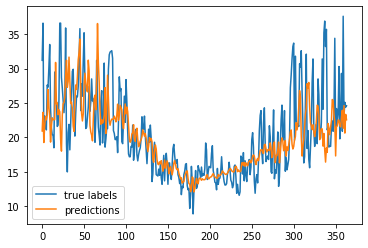

MSE: 23.075809


In [38]:
my_model.test_series(val)

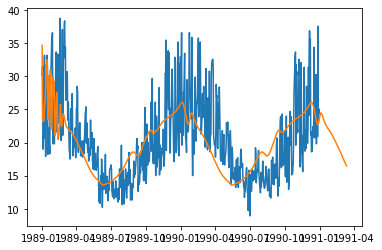

In [39]:
pred_series = my_model.predict(800)
val.plot()
pred_series.plot()